# 0. 초기 설정
- 드라이브 마운트
- 모듈 임포트
- gpu 연결(학습시)
- 데이터 폴더 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader 
from torch.utils.data import random_split
from torchvision import datasets
from torchvision import transforms 
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torchvision.models as models

from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# !pip install kaggle

# # kaggle.json upload
# from google.colab import files
# files.upload()

# # permmision warning 방지
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# # download
# !kaggle datasets download -d ammaralfaifi/5class-weather-status-image-classification

# # # unzip(압축풀기)
# !unzip -q 5class-weather-status-image-classification.zip -d weather/

# 1. 데이터 전처리
- 변환기(transform)
- train, valid, test 나누기

In [3]:
data_dir = '/kaggle/input/5class-weather-status-image-classification/data'

In [4]:
# 나만의 데이터셋 + 변환기
# 각 폴더 안에 이미지 파일 확장자가 여러개 => 하려면 모든 파일 불러오면됨

from torch.utils.data import Dataset
import glob
import cv2
from PIL import Image

class MyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = glob.glob(root_dir + '*/*/*')
        # print(root_dir + '*.*', self.image_paths)
        # print(len(self.image_paths))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        # print(image_filepath.split('/')[-2])
        # image
        image = Image.open(image_filepath).convert('RGB')

        transformed_image= self.transform(image)

        # label
        label_dict = {'cloudy': 0, 'foggy': 1, 'rainy': 2, 'snowy': 3, 'sunny': 4 }
        label = image_filepath.split('/')[-2]
        
        return transformed_image, label_dict[label]

In [5]:
transform = transforms.Compose([transforms.Resize([224, 224]),
                                transforms.RandomEqualize(p=0.3),
                                transforms.ColorJitter(brightness=0.4),
                                transforms.ToTensor()])

In [6]:
dataset_custom = MyDataset(root_dir=data_dir, transform=transform)

In [7]:
dataset_auto = datasets.ImageFolder(data_dir, transform=transform)

In [8]:
print('custom', len(dataset_custom))
print('auto', len(dataset_auto))

custom 18039
auto 18038


In [9]:
# dataset을 train, valid, test로 나누는 함수

def train_test_valid(dataset, valid_ratio, test_ratio):
    cloudy_list = []
    foggy_list = []
    rainy_list = []
    snowy_list = []
    sunny_list = []

    train_index = []
    valid_index = []
    test_index = []

    for i in range(len(dataset)):
        label = dataset[i][1]
        if label == 0:
            cloudy_list.append(i)
        elif label == 1:
            foggy_list.append(i)
        elif label == 2:
            rainy_list.append(i)
        elif label == 3:
            snowy_list.append(i)
        elif label == 4:
            sunny_list.append(i)

    for cnt, weather_index in enumerate((cloudy_list, foggy_list, rainy_list, snowy_list, sunny_list)):
        train_num = round(round(len(weather_index)*(1.0 - test_ratio)) * (1.0 - valid_ratio))
        valid_num = round(round(len(weather_index)*(1.0 - test_ratio)) * valid_ratio)
        test_num = round(len(weather_index)*test_ratio)

        # print(cnt, len(weather_index), train_num, valid_num, test_num)

        train_index += weather_index[:train_num]
        valid_index += weather_index[train_num: train_num+valid_num]
        test_index += weather_index[train_num+valid_num: train_num+valid_num+test_num]
        
    return train_index, valid_index, test_index

In [10]:
train_index, valid_index, test_index = train_test_valid(dataset_custom, valid_ratio=0.2, test_ratio=0.2)

print(len(train_index), len(valid_index), len(test_index))

trainset = Subset(dataset_custom, train_index)
validset = Subset(dataset_custom, valid_index)
testset = Subset(dataset_custom, test_index)

11546 2886 3607


In [ ]:
train_index, valid_index, test_index = train_test_valid(dataset_auto, valid_ratio=0.2, test_ratio=0.2)

print(len(train_index), len(valid_index), len(test_index))

trainset = Subset(dataset_auto, train_index)
validset = Subset(dataset_auto, valid_index)
testset = Subset(dataset_auto, test_index)

In [ ]:
class_train = []
class_valid = []
class_test = []

for i in range(5):
    train_weather = 0
    valid_weather = 0
    test_weather = 0

    for j in range(len(trainset)):
        if j < len(validset):
            if validset[j][1] == i:
                valid_weather += 1
        if j < len(testset):
            if testset[j][1] == i:
                test_weather += 1
        if trainset[j][1] == i:
            train_weather += 1

    class_train.append(train_weather)
    class_valid.append(valid_weather)
    class_test.append(test_weather)

print('train 속 weather 갯수 : ', class_train)
print('valid 속 weather 갯수 : ', class_valid)
print('test 속 weather 갯수  : ', class_test)

# 2. 시각화
- 이미지&라벨링 확인

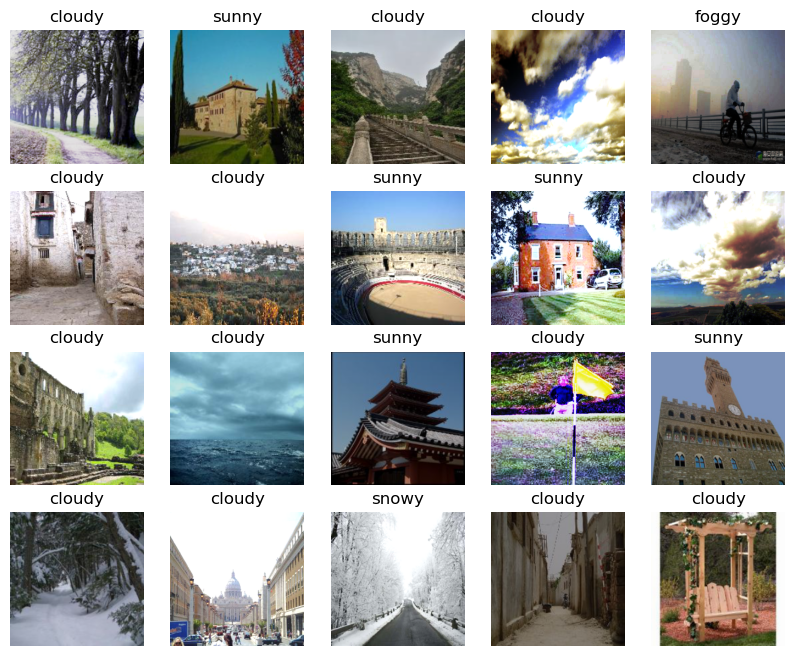

In [11]:
labels_map = {0:'cloudy', 1:'foggy', 2:'rainy', 3:'snowy', 4:'sunny'}

figure, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 8))
axes = axes.flatten()

for i in range(20):
    rand_i = np.random.randint(0, len(trainset))
    image, label= trainset[rand_i][0], trainset[rand_i][1]
    image = torch.permute(image, (1, 2, 0)) # image.permute(1, 2, 0)
    axes[i].axis('off')
    axes[i].imshow(image)
    axes[i].set_title(labels_map[label])

plt.show()

# 3. 배치
- dataload(batch_size, shuffle)

In [12]:
batch_size = 16

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [13]:
# custom의 경우
print('train : ', 11546 / 16,  2886 / 16, 3607 / 16)

# auto의 경우
print('auto  : ', 11545/ 16,  2886 / 16, 3607 / 16)

train :  721.625 180.375 225.4375
auto  :  721.5625 180.375 225.4375


In [14]:
print(type(trainloader), len(trainloader))
print(type(validloader), len(validloader))
print(type(testloader), len(testloader))

<class 'torch.utils.data.dataloader.DataLoader'> 722
<class 'torch.utils.data.dataloader.DataLoader'> 181
<class 'torch.utils.data.dataloader.DataLoader'> 226


In [15]:
train_iter = iter(trainloader)
images, labels = next(train_iter)
images.size(), labels.size()

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

# 4. model 설정
- 모델 작성 또는 전이학습

In [16]:
import torch.nn as nn # 파이토치에서 제공하는 다양한 계층 (Linear Layer, ....)
import torch.optim as optim # 옵티마이저 (경사하강법...)
import torch.nn.functional as F # 파이토치에서 제공하는 함수(활성화 함수...)

import torchvision.models as models

In [ ]:
model = models.GoogLeNet(init_weights=True)
model

In [ ]:
# 일단 전체를 학습이 안되게 고정
for parameter in model.parameters():
    parameter.requires_grad = False

# 분류기만 학습이 되도록 변경
for parameter in model.fc.parameters():
    parameter.requires_grad = True

In [ ]:
model.fc = nn.Sequential( nn.Linear(in_features=1024, out_features=5, bias=True) )

In [ ]:
model.to(device)

In [17]:
# ResNet으로 변경
model = models.resnet101(weights=True)
model

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
# 일단 전체를 학습이 안되게 고정
for parameter in model.parameters():
    parameter.requires_grad = False

# 분류기만 학습이 되도록 변경
for parameter in model.fc.parameters():
    parameter.requires_grad = True

In [19]:
model.fc = nn.Sequential( nn.Linear(in_features=2048, out_features=5, bias=True) )

In [20]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# 5. 학습

In [21]:
def validate(model, validloader, loss_fn):
    total = 0   
    correct = 0
    valid_loss = 0
    valid_accuracy = 0

  # 전방향 예측을 구할 때는 gradient가 필요가 없음음
    with torch.no_grad():
        for images, labels in validloader: # 이터레이터로부터 next()가 호출되며 미니배치를 반환(images, labels)      
            # images, labels : (torch.Size([16, 3, 224, 224]), torch.Size([16]))
            # 0. Data를 GPU로 보내기
            images, labels = images.to(device), labels.to(device)
            # 1. 입력 데이터 준비
            # not Flatten !!
            # images.resize_(images.size()[0], 784)

            # 2. 전방향(Forward) 예측
            logit = model(images) # 예측 점수
            _, preds = torch.max(logit, 1) # 배치에 대한 최종 예측
            # preds = logit.max(dim=1)[1] 
            correct += int((preds == labels).sum()) # 배치 중 맞은 것의 개수가 correct에 누적
            total += labels.shape[0] # 배치 사이즈만큼씩 total에 누적

            loss = loss_fn(logit, labels)
            valid_loss += loss.item() # tensor에서 값을 꺼내와서, 배치의 loss 평균값을 valid_loss에 누적

        valid_accuracy = correct / total
  
    return valid_loss, valid_accuracy

In [22]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

def train_loop(model, trainloader, loss_fn, epochs, optimizer):  
    
    steps = 0
    steps_per_epoch = len(trainloader) 
    min_loss = 1000000
    max_accuracy = 0
    trigger = 0
    patience = 7 

    for epoch in range(epochs):
        model.train() # 훈련 모드
        train_loss = 0
        for images, labels in trainloader: # 이터레이터로부터 next()가 호출되며 미니배치를 반환(images, labels)
            steps += 1
            # images, labels : (torch.Size([16, 3, 224, 224]), torch.Size([16]))
            # 0. Data를 GPU로 보내기
            images, labels = images.to(device), labels.to(device)
            # print(images.shape)
            # 1. 입력 데이터 준비
            # not Flatten !!
            # images.resize_(images.shape[0], 784) 

            # 2. 전방향(forward) 예측
            predict = model(images) # 예측 점수

            loss = loss_fn(predict, labels) # 예측 점수와 정답을 CrossEntropyLoss에 넣어 Loss값 반환
            # loss = loss_fn(predict.logits, labels) # GoogLeNet사용하는 경우
            
            # 3. 역방향(backward) 오차(Gradient) 전파
            optimizer.zero_grad() # Gradient가 누적되지 않게 하기 위해
            loss.backward() # 모델파리미터들의 Gradient 전파

            # 4. 경사 하강법으로 모델 파라미터 업데이트
            optimizer.step() # W <- W -lr*Gradient

            train_loss += loss.item()
            if (steps % steps_per_epoch) == 0 : 
                model.eval() # 평가 모드 : 평가에서 사용하지 않을 계층(배치 정규화, 드롭아웃)들을 수행하지 않게 하기 위해서
                valid_loss, valid_accuracy = validate(model, validloader, loss_fn)

                # tensorboard 시각화를 위한 로그 이벤트 등록
                writer.add_scalar('Train Loss', train_loss/len(trainloader), epoch+1)
                writer.add_scalar('Valid Loss', valid_loss/len(validloader), epoch+1)
                writer.add_scalars('Train Loss and Valid Loss',
                              {'Train' : train_loss/len(trainloader),
                                'Valid' : valid_loss/len(validloader)}, epoch+1)
                writer.add_scalar('Valid Accuracy', valid_accuracy, epoch+1)
                # -------------------------------------------

                print('Epoch : {}/{}.......'.format(epoch+1, epochs),            
                  'Train Loss : {:.3f}'.format(train_loss/len(trainloader)), 
                  'Valid Loss : {:.3f}'.format(valid_loss/len(validloader)), 
                  'Valid Accuracy : {:.3f}'.format(valid_accuracy)            
                  )

                # Best model 저장    
                # option 1 : valid_loss 모니터링
                # if valid_loss < min_loss: # 바로 이전 epoch의 loss보다 작으면 저장하기
                #   min_loss = valid_loss
                #   best_model_state = deepcopy(model.state_dict())          
                #   torch.save(best_model_state, 'best_checkpoint.pth')     

                # option 2 : valid_accuracy 모니터링      
                if valid_accuracy > max_accuracy : # 바로 이전 epoch의 accuracy보다 크면 저장하기
                    max_accuracy = valid_accuracy
                    best_model_state = deepcopy(model.state_dict())          
                    torch.save(best_model_state, 'best_checkpoint.pth')  
                # -------------------------------------------

                # Early Stopping (조기 종료)
                if valid_loss > min_loss: # valid_loss가 min_loss를 갱신하지 못하면
                    trigger += 1
                    print('trigger : ', trigger)
                    if trigger > patience:
                        print('Early Stopping !!!')
                        print('Training loop is finished !!')
                        writer.flush()   
                        return
                else:
                    trigger = 0
                    min_loss = valid_loss
                # -------------------------------------------

                # Learning Rate Scheduler
                scheduler.step(valid_loss)
                # -------------------------------------------
        
    writer.flush()
    return  

In [23]:
# 학습률
learning_rate = 0.001

# 손실함수
loss_fn = nn.CrossEntropyLoss()

# 옵티마이저(최적화함수, 예:경사하강법)
# 규제의 강도 설정 weight_decay
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 모니터링하고 있는 값(예:valid_loss)의 최소값(min) 또는 최대값(max) patience 기간동안 줄어들지 않을 때(OnPlateau) lr에 factor(0.1)를 곱해주는 전략
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)

In [24]:
epochs = 55
%time train_loop(model, trainloader, loss_fn, epochs, optimizer)
writer.close()

Epoch : 1/55....... Train Loss : 0.843 Valid Loss : 0.621 Valid Accuracy : 0.753
Epoch : 2/55....... Train Loss : 0.710 Valid Loss : 0.612 Valid Accuracy : 0.769
Epoch : 3/55....... Train Loss : 0.669 Valid Loss : 0.538 Valid Accuracy : 0.794
Epoch : 4/55....... Train Loss : 0.642 Valid Loss : 0.578 Valid Accuracy : 0.775
trigger :  1
Epoch : 5/55....... Train Loss : 0.621 Valid Loss : 0.571 Valid Accuracy : 0.780
trigger :  2
Epoch : 6/55....... Train Loss : 0.628 Valid Loss : 0.680 Valid Accuracy : 0.759
trigger :  3
Epoch : 7/55....... Train Loss : 0.607 Valid Loss : 0.505 Valid Accuracy : 0.807
Epoch : 8/55....... Train Loss : 0.594 Valid Loss : 0.545 Valid Accuracy : 0.795
trigger :  1
Epoch : 9/55....... Train Loss : 0.583 Valid Loss : 0.551 Valid Accuracy : 0.795
trigger :  2
Epoch : 10/55....... Train Loss : 0.597 Valid Loss : 0.582 Valid Accuracy : 0.778
trigger :  3
Epoch : 11/55....... Train Loss : 0.580 Valid Loss : 0.544 Valid Accuracy : 0.797
trigger :  4
Epoch : 12/55...

# 6. 결과예측

In [25]:
# testloader에서 미니 배치 가져오기
test_iter = iter(testloader)
images, labels = next(test_iter)
images, labels = images.to(device), labels.to(device)
print(images.size(), labels.size())

# random한 index로 이미지 한장 준비하기
rnd_idx = 10
print(images[rnd_idx].shape, labels[rnd_idx])

torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([3, 224, 224]) tensor(0, device='cuda:0')


In [26]:
model.eval()
with torch.no_grad():
    logit = model(images[rnd_idx].unsqueeze(0)) # model.forward()에서는 배치가 적용된 4차원 입력 기대

pred = logit.max(dim=1)[1]
print(pred == labels[rnd_idx]) # True : 잘 예측

tensor([True], device='cuda:0')


pred: tensor([0], device='cuda:0') labels: tensor(0, device='cuda:0')
cloudy cloudy


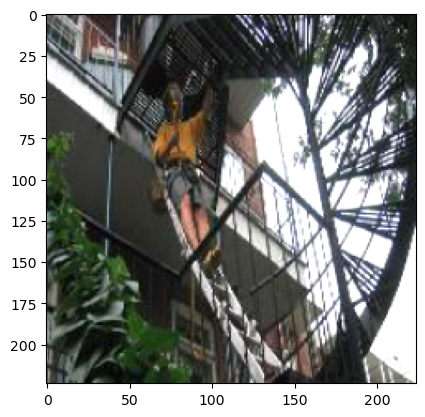

In [27]:
print("pred:", pred, "labels:", labels[rnd_idx])
print(labels_map[pred.cpu().item()], labels_map[labels[rnd_idx].cpu().item()])
plt.imshow(images[rnd_idx].permute(1, 2, 0).cpu())
plt.show()

# 7. test

In [28]:
def evaluation(model, testloader, loss_fn):
    total = 0   
    correct = 0
    test_loss = 0
    test_accuracy = 0

    # 전방향 예측을 구할 때는 gradient가 필요가 없음음
    with torch.no_grad():
        for images, labels in testloader: # 이터레이터로부터 next()가 호출되며 미니배치를 반환(images, labels)
            # 0. Data를 GPU로 보내기
            images, labels = images.to(device), labels.to(device)

            # 1. 입력 데이터 준비
            # not Flatten
            # images.resize_(images.size()[0], 784)
      
            # 2. 전방향(Forward) 예측
            logit = model(images) # 예측 점수
            _, preds = torch.max(logit, 1) # 배치에 대한 최종 예측
            # preds = logit.max(dim=1)[1] 
            correct += int((preds == labels).sum()) # 배치치 중 맞은 것의 개수가 correct에 누적
            total += labels.shape[0] # 배치 사이즈만큼씩 total에 누적

            loss = loss_fn(logit, labels)
            test_loss += loss.item() # tensor에서 값을 꺼내와서, 배치의 loss 평균값을 valid_loss에 누적

        test_accuracy = correct / total
   
    print('Test Loss : {:.3f}'.format(test_loss/len(testloader)), 
            'Test Accuracy : {:.3f}'.format(test_accuracy))

model.eval()
evaluation(model, testloader, loss_fn)  

Test Loss : 0.509 Test Accuracy : 0.804


# 8. model 저장